In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from scipy.cluster import hierarchy
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

In [2]:
data = pd.read_csv("Data/Groceries_dataset.csv")
data.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [3]:
print("We have data from the period between {} and {}".format(min(data['Date']), max(data['Date'])))

We have data from the period between 01-01-2014 and 31-10-2015


In [5]:
print("Total {} rows of data".format(len(data)))
print("Total {} distinct customers".format(len(set(data['Member_number']))))
print("Total {} distinct products".format(len(set(data['itemDescription']))))

Total 38765 rows of data
Total 3898 distinct customers
Total 167 distinct products


In [19]:
# We only want to know whether a customer has purchased a particular product within window, no need to keep multiple entries
agg_data = data[['Member_number', 'itemDescription']].drop_duplicates()
print("Total {} rows of data".format(len(agg_data)))
print("Total {} distinct customers".format(len(set(agg_data['Member_number']))))
print("Total {} distinct products".format(len(set(agg_data['itemDescription']))))

Total 34766 rows of data
Total 3898 distinct customers
Total 167 distinct products


In [24]:
# Now we do a quick count to see what are the most/least popular products
prod_count = agg_data[['itemDescription', 'Member_number']].groupby(['itemDescription'])['Member_number'] \
                    .count() \
                    .reset_index(name='count') \
                    .sort_values(['count'], ascending=False)
print("Top selling: {}".format(prod_count['itemDescription'].iloc[0]))
print("Worst selling: {}".format(prod_count['itemDescription'].iloc[len(prod_count)-1]))

Top selling: whole milk
Worst selling: preservation products


In [25]:
# Check out the cutoffs for top and bottom 5%, this might be useful later for getting a gaussian curve for dissimilarity density
prod_count['count'].dropna().quantile([0.05, 0.95])

0.05      6.6
0.95    779.0
Name: count, dtype: float64

In [37]:
filtered_prods = prod_count[(prod_count['count']>6.6) & (prod_count['count']<779)].itemDescription

prod_list = agg_data[agg_data.itemDescription.isin(filtered_prods)]
prod_list['purchase'] = 1

prod_list_pivot = prod_list.pivot(values='purchase', index='Member_number', columns='itemDescription')
df = prod_list_pivot.reset_index().drop(columns = ['Member_number']).fillna(0).astype(int)

df.head()

C:\Users\Leslie\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,...,tea,tidbits,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,zwieback
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
dm = pairwise_distances(df.T.values, metric = 'yule')
dm = pd.DataFrame(dm, index = df.columns, columns = df.columns)
dm.head()

C:\Users\Leslie\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,...,tea,tidbits,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,zwieback
itemDescription,,,,,,,,,,,,,,,,,,,,,
Instant food products,0.000000,1.095195,2.000000,2.000000,1.316597,2.000000,0.873756,1.253239,0.967339,0.918811,...,2.000000,2.000000,0.553936,0.541740,0.902564,1.094446,2.0,0.777149,0.939301,0.620779
UHT-milk,1.095195,0.000000,0.704349,0.854123,0.874069,2.000000,0.935777,0.903799,0.869410,0.890613,...,0.545987,1.289641,1.116713,1.620493,0.906997,0.921251,2.0,1.055594,0.874108,0.649682
abrasive cleaner,2.000000,0.704349,0.000000,2.000000,2.000000,2.000000,0.762936,0.934382,1.169768,0.786794,...,2.000000,2.000000,0.601898,2.000000,1.224410,0.909183,2.0,0.767293,0.990211,2.000000
artif. sweetener,2.000000,0.854123,2.000000,0.000000,2.000000,2.000000,1.088082,0.705715,1.306107,0.957007,...,2.000000,2.000000,0.295387,2.000000,1.006352,1.074131,2.0,1.142998,2.000000,2.000000
baking powder,1.316597,0.874069,2.000000,2.000000,0.000000,0.681093,0.910777,0.795499,0.703643,0.867562,...,0.913884,2.000000,1.105623,2.000000,1.029837,0.966063,2.0,1.104967,1.158962,0.515035


C:\Users\Leslie\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


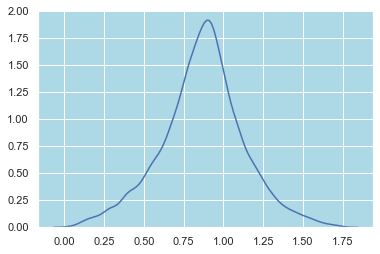

In [46]:
# Here we visualise our disimilarity matrix density, note that we need this to be gaussian for good clustering results
dm_plot = pairwise_distances(df.T.values, metric = "yule")

sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'white'})
sns.kdeplot(dm_plot[(dm_plot>0) & (dm_plot<2)].flatten())

C:\Users\Leslie\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


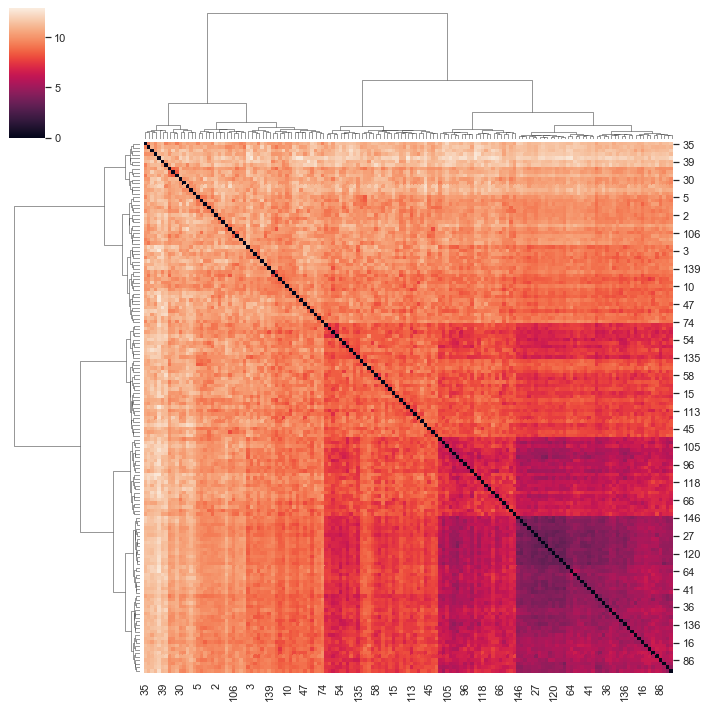

In [47]:
dm2 = pairwise_distances(dm.values, metric = 'euclidean')

linkage = hc.linkage(dm2, method = 'ward')
sns.clustermap(dm2, row_linkage = linkage, col_linkage = linkage)

C:\Users\Leslie\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


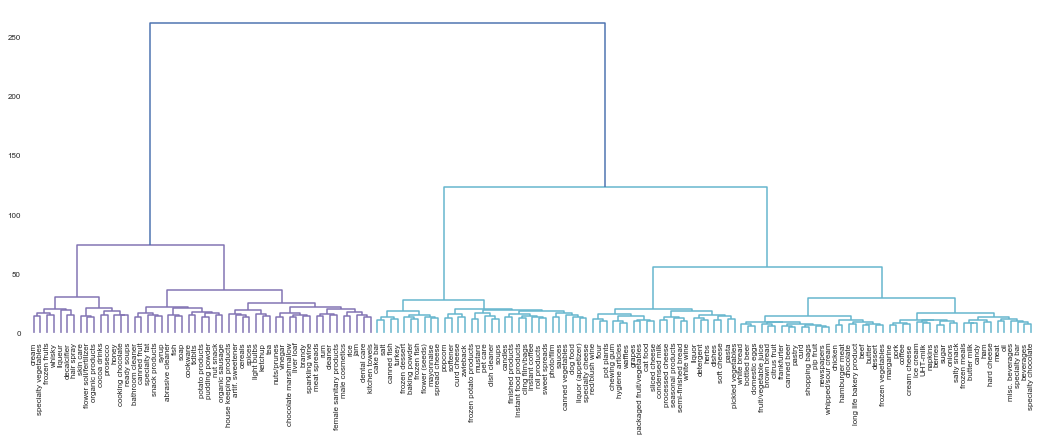

In [56]:
z = hierarchy.linkage(dm2, 'ward')

hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 1, figsize=(18, 6))
axes.set_facecolor('white')
dd = hierarchy.dendrogram(z, ax=axes, leaf_rotation=90, truncate_mode='level', leaf_font_size=8, labels=dm.index)
hierarchy.set_link_color_palette(None)
axes.tick_params(axis="x", labelsize=8)
axes.tick_params(axis='y', labelsize=8)
plt.show()

In [57]:
model = AgglomerativeClustering(affinity='euclidean', linkage='ward', memory=None, n_clusters=10)
model.fit(dm)

labels = model.labels_
labels = pd.DataFrame(data = labels)

dm2 = dm.reset_index()
labels2 = labels.rename(columns={"index":"index", 0:"cluster"})
labels2 = labels2.reset_index()

C:\Users\Leslie\AppData\Roaming\Python\Python37\site-packages\scipy\cluster\hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [58]:
clusters = pd.concat([dm2, labels2], axis = 1)
clusters.head()

,itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baking powder,bathroom cleaner,beef,berries,beverages,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,zwieback,index,cluster
0,Instant food products,0.000000,1.095195,2.000000,2.000000,1.316597,2.000000,0.873756,1.253239,0.967339,...,0.553936,0.541740,0.902564,1.094446,2.0,0.777149,0.939301,0.620779,0,2
1,UHT-milk,1.095195,0.000000,0.704349,0.854123,0.874069,2.000000,0.935777,0.903799,0.869410,...,1.116713,1.620493,0.906997,0.921251,2.0,1.055594,0.874108,0.649682,1,7
2,abrasive cleaner,2.000000,0.704349,0.000000,2.000000,2.000000,2.000000,0.762936,0.934382,1.169768,...,0.601898,2.000000,1.224410,0.909183,2.0,0.767293,0.990211,2.000000,2,5
3,artif. sweetener,2.000000,0.854123,2.000000,0.000000,2.000000,2.000000,1.088082,0.705715,1.306107,...,0.295387,2.000000,1.006352,1.074131,2.0,1.142998,2.000000,2.000000,3,0
4,baking powder,1.316597,0.874069,2.000000,2.000000,0.000000,0.681093,0.910777,0.795499,0.703643,...,1.105623,2.000000,1.029837,0.966063,2.0,1.104967,1.158962,0.515035,4,4


In [60]:
list(clusters[clusters.cluster == 0].itemDescription)

['artif. sweetener',
 'cereals',
 'chocolate marshmallow',
 'house keeping products',
 'light bulbs',
 'meat spreads',
 'nut snack',
 'spices',
 'tea']

In [61]:
list(clusters[clusters.cluster == 1].itemDescription)

['cocoa drinks',
 'cookware',
 'ketchup',
 'organic sausage',
 'potato products',
 'pudding powder',
 'specialty vegetables',
 'tidbits']

In [62]:
list(clusters[clusters.cluster == 2].itemDescription)

['Instant food products',
 'bathroom cleaner',
 'brandy',
 'canned fruit',
 'cling film/bags',
 'curd cheese',
 'dental care',
 'jam',
 'kitchen towels',
 'male cosmetics',
 'popcorn',
 'rice',
 'snack products',
 'softener',
 'specialty fat',
 'syrup',
 'zwieback']

In [63]:
list(clusters[clusters.cluster == 3].itemDescription)

['frozen fruits', 'liqueur', 'whisky']

In [64]:
list(clusters[clusters.cluster == 4].itemDescription)

['baking powder',
 'cake bar',
 'candles',
 'canned fish',
 'canned vegetables',
 'dish cleaner',
 'dog food',
 'finished products',
 'flower (seeds)',
 'frozen fish',
 'instant coffee',
 'liquor (appetizer)',
 'mayonnaise',
 'pet care',
 'roll products ',
 'salt',
 'sauces',
 'soups',
 'sparkling wine',
 'specialty cheese',
 'spread cheese',
 'sweet spreads',
 'turkey']

In [65]:
list(clusters[clusters.cluster == 5].itemDescription)

['abrasive cleaner',
 'decalcifier',
 'fish',
 'liver loaf',
 'nuts/prunes',
 'photo/film',
 'soap',
 'vinegar']

In [66]:
list(clusters[clusters.cluster == 6].itemDescription)

['cooking chocolate',
 'cream',
 'hair spray',
 'honey',
 'prosecco',
 'ready soups']

In [67]:
list(clusters[clusters.cluster == 7].itemDescription)

['UHT-milk',
 'beef',
 'berries',
 'beverages',
 'bottled beer',
 'brown bread',
 'butter',
 'butter milk',
 'candy',
 'canned beer',
 'cat food',
 'chewing gum',
 'chicken',
 'chocolate',
 'citrus fruit',
 'coffee',
 'condensed milk',
 'cream cheese ',
 'curd',
 'dessert',
 'detergent',
 'dishes',
 'domestic eggs',
 'flour',
 'frankfurter',
 'frozen dessert',
 'frozen meals',
 'frozen vegetables',
 'fruit/vegetable juice',
 'grapes',
 'ham',
 'hamburger meat',
 'hard cheese',
 'herbs',
 'hygiene articles',
 'ice cream',
 'liquor',
 'long life bakery product',
 'margarine',
 'meat',
 'misc. beverages',
 'napkins',
 'newspapers',
 'oil',
 'onions',
 'packaged fruit/vegetables',
 'pasta',
 'pastry',
 'pickled vegetables',
 'pip fruit',
 'pork',
 'pot plants',
 'processed cheese',
 'red/blush wine',
 'salty snack',
 'seasonal products',
 'semi-finished bread',
 'shopping bags',
 'sliced cheese',
 'soft cheese',
 'specialty bar',
 'specialty chocolate',
 'sugar',
 'waffles',
 'whipped/sour

In [68]:
list(clusters[clusters.cluster == 8].itemDescription)

['cleaner',
 'female sanitary products',
 'frozen potato products',
 'mustard',
 'rum']

In [69]:
list(clusters[clusters.cluster == 9].itemDescription)

['flower soil/fertilizer', 'organic products', 'skin care']